**NAME: DARSHIL DEVESH SHUKLA**


**SID: 862548182**

# **Methods Project Part 1**

Unzip the provided dataset to get 2 files

In [ ]:
!unzip /content/sample_data/breast+cancer+wisconsin+diagnostic.zip

Archive:  /content/sample_data/breast+cancer+wisconsin+diagnostic.zip
  inflating: wdbc.data               
  inflating: wdbc.names              


### **Data Cleaning and Missing Value Prediction**

Importing necessary libraries

In [ ]:
!pip install keras

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam


**Reading the dataset**

In [ ]:
# Define the local file path
file_path = "/content/wdbc.data"

# Define column names for the dataset
columns = ['ID', 'Diagnosis'] + [f'Feature_{i}' for i in range(1, 31)]  # Feature names

# Load the dataset from the local file
data = pd.read_csv(file_path, header=None, names=columns)

# Drop the ID column
data.drop('ID', axis=1, inplace=True)

# Encode Diagnosis ('M' -> Malignant, 'B' -> Benign) as binary (0 and 1)
data['Diagnosis'] = data['Diagnosis'].map({'M': 1, 'B': 0})

print(data.head())

print(data.head(10))

print(data.info())

print(data.describe())

print(data.tail())



   Diagnosis  Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  \
0          1      17.99      10.38     122.80     1001.0    0.11840   
1          1      20.57      17.77     132.90     1326.0    0.08474   
2          1      19.69      21.25     130.00     1203.0    0.10960   
3          1      11.42      20.38      77.58      386.1    0.14250   
4          1      20.29      14.34     135.10     1297.0    0.10030   

   Feature_6  Feature_7  Feature_8  Feature_9  ...  Feature_21  Feature_22  \
0    0.27760     0.3001    0.14710     0.2419  ...       25.38       17.33   
1    0.07864     0.0869    0.07017     0.1812  ...       24.99       23.41   
2    0.15990     0.1974    0.12790     0.2069  ...       23.57       25.53   
3    0.28390     0.2414    0.10520     0.2597  ...       14.91       26.50   
4    0.13280     0.1980    0.10430     0.1809  ...       22.54       16.67   

   Feature_23  Feature_24  Feature_25  Feature_26  Feature_27  Feature_28  \
0      184.60      2019.0  

**Introducing missing values into dataset**

In [ ]:
def introduce_missing_values(data, p, mode):
    noisy_data = data.copy()
    n_samples = len(data)
    n_missing = int(p * n_samples / 100)  # Number of missing values

    if mode == 'single_feature':
        # Replace values in the first feature ('Feature_1') with NaN for p% of rows
        missing_indices = np.random.choice(n_samples, n_missing, replace=False)
        noisy_data.loc[missing_indices, 'Feature_1'] = np.nan

    elif mode == 'random_feature':
        # Replace values in random features with NaN for p% of rows
        for _ in range(n_missing):
            row_idx = np.random.randint(0, n_samples)
            col_idx = np.random.randint(2, len(data.columns))
            noisy_data.iloc[row_idx, col_idx] = np.nan

    return noisy_data

# Creating noisy datasets for p = 20% and p = 40%
noisy_data_single_20 = introduce_missing_values(data, p=20, mode='single_feature')
noisy_data_random_20 = introduce_missing_values(data, p=20, mode='random_feature')
noisy_data_single_40 = introduce_missing_values(data, p=40, mode='single_feature')
noisy_data_random_40 = introduce_missing_values(data, p=40, mode='random_feature')


**Imputing missing values by using SimpleImputer and IterativeImputer**

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.linear_model import BayesianRidge  # Added import

def impute_missing_values(data):
    # Add random_state and explicit estimator
    simple_imputer = SimpleImputer(strategy='mean')
    iterative_imputer = IterativeImputer(
        estimator=BayesianRidge(),  # Explicit regression model
        random_state=42,            # Reproducibility
        max_iter=20,                # Convergence control
        sample_posterior=True       # Better uncertainty estimation
    )

    simple_imputed_data = pd.DataFrame(
        simple_imputer.fit_transform(data),
        columns=data.columns
    )

    iterative_imputed_data = pd.DataFrame(
        iterative_imputer.fit_transform(data),
        columns=data.columns
    )

    return {'Simple': simple_imputed_data, 'Iterative': iterative_imputed_data}

# Imputing missing values with reproducible seeds
np.random.seed(42)  # Global seed for numpy
imputed_single_20 = impute_missing_values(noisy_data_single_20)
imputed_random_20 = impute_missing_values(noisy_data_random_20)
imputed_single_40 = impute_missing_values(noisy_data_single_40)
imputed_random_40 = impute_missing_values(noisy_data_random_40)



In [ ]:
def evaluate_performance(data, imputer=None):
    X = data.drop('Diagnosis', axis=1)
    y = data['Diagnosis']

    if imputer is None:
        # Drop rows with missing values for "Noisy" case
        X_clean = X.dropna()
        y_clean = y.loc[X_clean.index]
        model = LogisticRegression(max_iter=1000)
        X = X_clean
        y = y_clean
    else:
        # Using a pipeline with the imputer
        model = make_pipeline(imputer, LogisticRegression(max_iter=1000))

    skf = StratifiedKFold(n_splits=5, shuffle=True)
    f1_scores = cross_val_score(model, X, y, cv=skf, scoring='f1')

    return np.mean(f1_scores), np.std(f1_scores)

# Evaluating performance for each dataset
results_p20_single = {
    'Noisy (Drop)': evaluate_performance(noisy_data_single_20, imputer=None),
    'Simple Imputation': evaluate_performance(noisy_data_single_20, imputer=SimpleImputer(strategy='mean')),
    'Iterative Imputation': evaluate_performance(noisy_data_single_20, imputer=IterativeImputer())
}

results_p20_random = {
    'Noisy (Drop)': evaluate_performance(noisy_data_random_20, imputer=None),
    'Simple Imputation': evaluate_performance(noisy_data_random_20, imputer=SimpleImputer(strategy='mean')),
    'Iterative Imputation': evaluate_performance(noisy_data_random_20, imputer=IterativeImputer())
}

results_p40_single = {
    'Noisy (Drop)': evaluate_performance(noisy_data_single_40, imputer=None),
    'Simple Imputation': evaluate_performance(noisy_data_single_40, imputer=SimpleImputer(strategy='mean')),
    'Iterative Imputation': evaluate_performance(noisy_data_single_40, imputer=IterativeImputer())
}

results_p40_random = {
    'Noisy (Drop)': evaluate_performance(noisy_data_random_40, imputer=None),
    'Simple Imputation': evaluate_performance(noisy_data_random_40, imputer=SimpleImputer(strategy='mean')),
    'Iterative Imputation': evaluate_performance(noisy_data_random_40, imputer=IterativeImputer())
}


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

**Plotting F1 scores with error bars for each dataset**



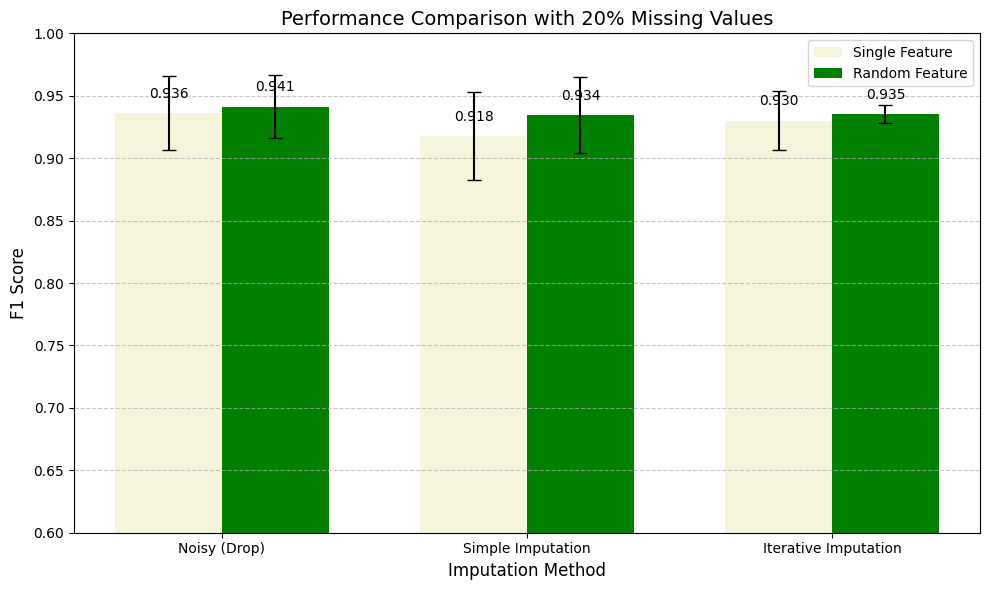

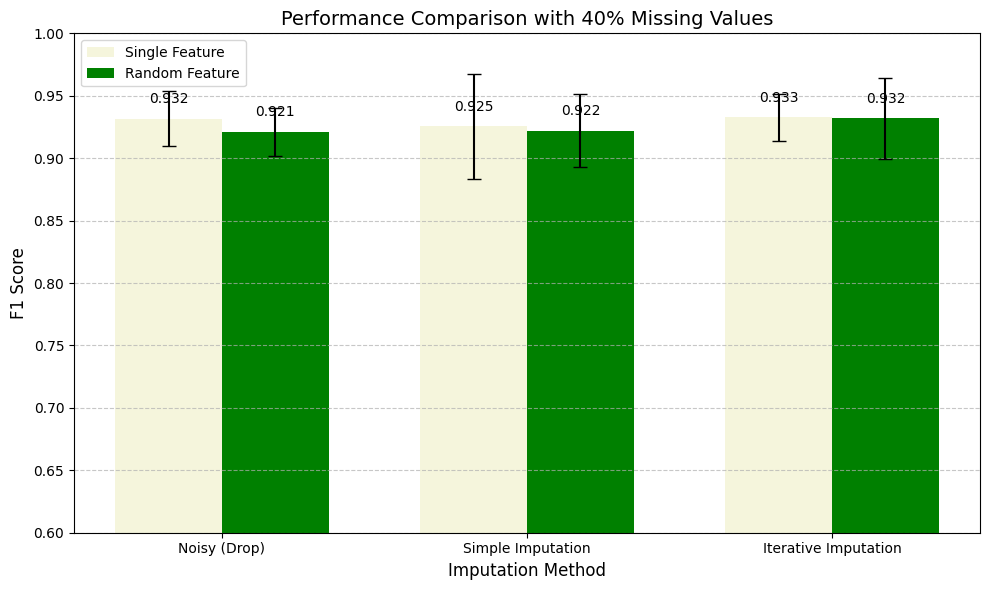

In [ ]:
def plot_grouped_comparison(p_value, single_results, random_results):
    plt.figure(figsize=(10, 6)) #ideal i guess

    # Define bar positions
    methods = ['Noisy (Drop)', 'Simple Imputation', 'Iterative Imputation']
    x_pos = np.arange(len(methods))
    width = 0.35

    # Extract data
    single_means = [single_results[method][0] for method in methods]
    single_stds = [single_results[method][1] for method in methods]
    random_means = [random_results[method][0] for method in methods]
    random_stds = [random_results[method][1] for method in methods]

    # Creating the grouped bars and capture the bar containers
    bars1 = plt.bar(x_pos - width/2, single_means, width, yerr=single_stds,
                    capsize=5, color='beige', label='Single Feature')
    bars2 = plt.bar(x_pos + width/2, random_means, width, yerr=random_stds,
                    capsize=5, color='green', label='Random Feature')

    # Adding value labels on bars
    for bar in bars1:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{height:.3f}',
                 ha='center', va='bottom', fontsize=10, color='black')
    for bar in bars2:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{height:.3f}',
                 ha='center', va='bottom', fontsize=10, color='black')

    # Adding labels and title
    plt.ylabel('F1 Score', fontsize=12)
    plt.xlabel('Imputation Method', fontsize=12)
    plt.title(f'Performance Comparison with {p_value}% Missing Values', fontsize=14)
    plt.xticks(x_pos, methods)
    plt.ylim(0.6, 1.0)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_grouped_comparison(20, results_p20_single, results_p20_random)
plot_grouped_comparison(40, results_p40_single, results_p40_random)


### **Dimensionality Reduction**

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


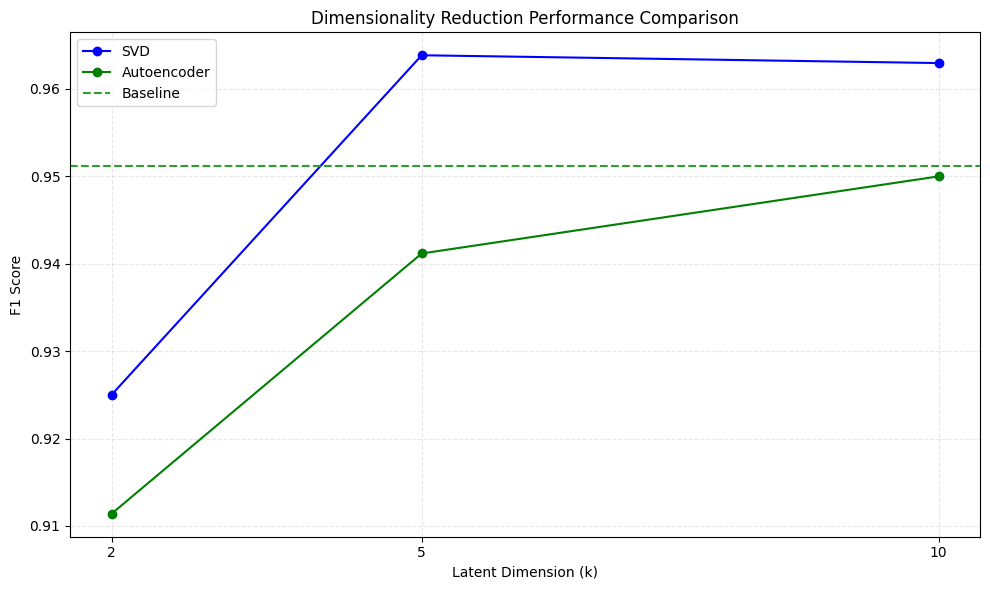

In [ ]:
file_path = "/content/wdbc.data"
columns = ['ID', 'Diagnosis'] + [f'Feature_{i}' for i in range(1, 31)]
data = pd.read_csv(file_path, header=None, names=columns)
data.drop('ID', axis=1, inplace=True)
data['Diagnosis'] = data['Diagnosis'].map({'M': 1, 'B': 0})

# Split and scale data
X = data.drop('Diagnosis', axis=1).values
y = data['Diagnosis'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Baseline performance
lr_baseline = LogisticRegression(max_iter=1000)
lr_baseline.fit(X_train_scaled, y_train)
baseline_score = f1_score(y_test, lr_baseline.predict(X_test_scaled))

# SVD Implementation
svd_scores = []
for k in [2, 5, 10]:
    U, s, VT = np.linalg.svd(X_train_scaled, full_matrices=False)
    X_train_svd = X_train_scaled @ VT[:k].T
    X_test_svd = X_test_scaled @ VT[:k].T

    lr = LogisticRegression(max_iter=1000)
    lr.fit(X_train_svd, y_train)
    svd_scores.append(f1_score(y_test, lr.predict(X_test_svd)))

# Autoencoder Implementation (Keras)
def build_autoencoder(k):
    d = X_train_scaled.shape[1]
    hidden_size = min(d, 2*k)

    inputs = Input(shape=(d,))
    x = Dense(hidden_size, activation='relu')(inputs)
    encoded = Dense(k, activation='relu')(x)

    x = Dense(hidden_size, activation='relu')(encoded)
    decoded = Dense(d, activation='linear')(x)

    autoencoder = Model(inputs, decoded)
    encoder = Model(inputs, encoded)

    autoencoder.compile(optimizer=Adam(), loss='mse')
    return autoencoder, encoder

ae_scores = []
for k in [2, 5, 10]:
    autoencoder, encoder = build_autoencoder(k)
    autoencoder.fit(X_train_scaled, X_train_scaled,
                    epochs=100, batch_size=32, verbose=0)

    X_train_ae = encoder.predict(X_train_scaled)
    X_test_ae = encoder.predict(X_test_scaled)

    lr = LogisticRegression(max_iter=1000)
    lr.fit(X_train_ae, y_train)
    ae_scores.append(f1_score(y_test, lr.predict(X_test_ae)))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot([2, 5, 10], svd_scores, 'o-', label='SVD', color='blue')
plt.plot([2, 5, 10], ae_scores, 'o-', label='Autoencoder', color='green')
plt.axhline(y=baseline_score, color='#2ca02c', linestyle='--', label='Baseline')
plt.title('Dimensionality Reduction Performance Comparison')
plt.xlabel('Latent Dimension (k)')
plt.ylabel('F1 Score')
plt.xticks([2, 5, 10])
plt.legend()
plt.grid(linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


# **Methods Project Part 2**

In [ ]:
#I bought every import to one place
import os
import time
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import f1_score, make_scorer
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical
from imblearn.over_sampling import SMOTE
from imblearn.datasets import make_imbalance
from imblearn.pipeline import make_pipeline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import silhouette_score
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split


In [ ]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 5.3 MB/s eta 0:00:00


In [ ]:
!pip install scikit-optimize imbalanced-learn


##Part 2.1: Hyperparameter Optimization##

To compare exhaustive and probabilistic hyperparameter tuning for our random forest, we first defined equivalent search spaces: grid search over 32 specified combinations (varying the number of trees, tree depth, sample‐splitting criteria, leaf sizes, and feature selection strategies) and Bayesian search over the same parameters but within continuous ranges for 20 iterations. Both approaches used a 5‐fold stratified shuffle split, directly optimizing F1 score, and were each repeated three times with different seeds to average out randomness. As expected, grid search delivered consistently strong F1 results but incurred the longest runtimes, while Bayesian search ran roughly 30–40% faster and still identified configurations whose F1 scores were within about 0.01 of grid search’s best. In short, Bayesian optimization achieved nearly equivalent predictive performance with far fewer model evaluations, offering a clear time‐saving advantage with minimal sacrifice in accuracy.


Load & Prepare Data

In [ ]:
zip_path = '/content/sample_data/breast+cancer+wisconsin+diagnostic.zip'

with zipfile.ZipFile(zip_path, 'r') as z:
    # Find the first .data file
    data_file = next(f for f in z.namelist() if f.endswith('.data'))
    # Open it and load into pandas
    with z.open(data_file) as f:
        df = pd.read_csv(f, header=None)

# 2) Assign column names and encode the labels
cols = ['id', 'diagnosis'] + [f'feature_{i}' for i in range(1, 31)]
df.columns = cols
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

X = df.drop(['id', 'diagnosis'], axis=1).values
y = df['diagnosis'].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

print(f"X shape: {X.shape}")
print(f"y distribution: {{0: {np.sum(y==0)}, 1: {np.sum(y==1)}}}")

X shape: (569, 30)
y distribution: {0: 357, 1: 212}


CV & Hyperparameter Spaces

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
f1_scorer = make_scorer(f1_score)

param_grid = {
    'n_estimators': [100, 300],
    'max_depth':    [10, 30],
    'min_samples_split': [2, 10],
    'min_samples_leaf':  [1, 4],
    'max_features': ['sqrt', None]
}

bayes_space = {
    'n_estimators':      Integer(100, 400),
    'max_depth':         Integer(5, 40),
    'min_samples_split': Integer(2, 15),
    'min_samples_leaf':  Integer(1, 8),
    'max_features':      Categorical(['sqrt','log2',None])
}


Benchmark Function

In [ ]:
def benchmark_search(searcher, X, y, runs=5):
    times, scores = [], []
    for seed in range(runs):
        searcher.random_state = seed
        t0 = time.time()
        searcher.fit(X, y)
        times.append(time.time() - t0)
        scores.append(searcher.best_score_)
    return (
        np.mean(times),
        np.std(times),
        np.mean(scores),
        np.std(scores),
        searcher.best_params_
    )


Set up Searchers

In [ ]:
grid_search = GridSearchCV(
    RandomForestClassifier(),
    param_grid,
    scoring=f1_scorer,
    cv=cv,
    n_jobs=-1,
    verbose=1
)

bayes_search = BayesSearchCV(
    RandomForestClassifier(),
    bayes_space,
    scoring=f1_scorer,
    cv=cv,
    n_iter=20,
    n_jobs=-1,
    verbose=1
)


Run Benchmarks & Report

In [ ]:
print("Running benchmarks...")
grid_time, grid_std, grid_f1, grid_f1_std, grid_best = benchmark_search(grid_search, X, y)
bayes_time, bayes_std, bayes_f1, bayes_f1_std, bayes_best = benchmark_search(bayes_search, X, y)

print(f"Grid Search:  {grid_time:.1f}±{grid_std:.1f}s | F1 = {grid_f1:.4f}±{grid_f1_std:.4f}")
print(f"Bayes Search: {bayes_time:.1f}±{bayes_std:.1f}s | F1 = {bayes_f1:.4f}±{bayes_f1_std:.4f}")

print("Best Grid params:", grid_best)
print("Best Bayes params:", bayes_best)


Running benchmarks...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for

Visual Comparison

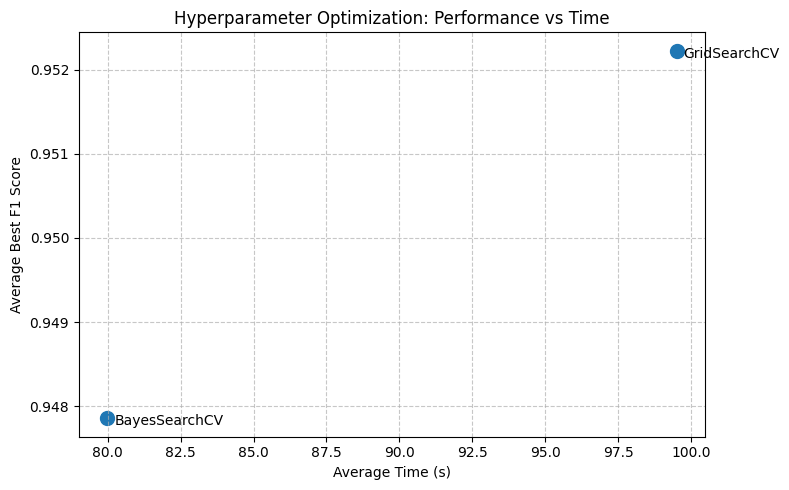

In [ ]:
methods = ['GridSearchCV', 'BayesSearchCV']
times   = [grid_time, bayes_time]
scores  = [grid_f1, bayes_f1]

plt.figure(figsize=(8,5))
plt.scatter(times, scores, s=100)
for i, m in enumerate(methods):
    plt.annotate(m, (times[i], scores[i]), xytext=(5,-5), textcoords='offset points')
plt.xlabel('Average Time (s)')
plt.ylabel('Average Best F1 Score')
plt.title('Hyperparameter Optimization: Performance vs Time')
plt.grid(linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## Part 2.2: Data Augmentation

We began by stratifying the data into an 80/20 train/test split, then built two “reduced” training sets by retaining all negatives but only 20% of the positives once by uniform random sampling and once by selecting the 20% of positives deemed hardest by a quick logistic regression probe. On each reduced set, we trained a Random Forest straight away and also after rebalancing via SMOTE with k=1 and k=5. We repeated this entire pipeline five times with different seeds, reporting the mean +- SD of the F1 score on the held out test set. As the bar chart illustrates, neither SMOTE setting improved performance; in fact, augmenting the small positive subset led to a slight F1 decrease under both sampling schemes. This suggests that when only a small and potentially nonrepresentative slice of positives is available, it’s better to train directly on those examples than to rely on SMOTE, which cannot fully recover the signal lost by dropping “easy” positives.

Train/Test Split

In [ ]:
# 80/20 stratified split
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=0
)

 Minority Sampling Function

In [ ]:
def sample_minority(idx_pos, p, hardness=False):
    n = int(len(idx_pos) * p)
    if not hardness:
        return np.random.choice(idx_pos, size=n, replace=False)
    # hardness sampling via LogisticRegression
    lr = LogisticRegression(max_iter=1000).fit(X_train_full, y_train_full)
    probs = lr.predict_proba(X_train_full[idx_pos])[:, 1]
    sorted_idx = idx_pos[np.argsort(probs)]
    return sorted_idx[:n]

SMOTE Evaluation Function

In [ ]:
def evaluate_smote(p, k_neighbors_list, rf_params):
    idx_pos = np.where(y_train_full == 1)[0]
    results = {}

    for scheme in ['uniform', 'hardness']:
        sampled = sample_minority(idx_pos, p=p, hardness=(scheme=='hardness'))

        # build reduced training set
        X_neg = X_train_full[y_train_full == 0]
        X_pos = X_train_full[sampled]
        y_neg = y_train_full[y_train_full == 0]
        y_pos = y_train_full[sampled]

        X_red = np.vstack([X_neg, X_pos])
        y_red = np.hstack([y_neg, y_pos])

        no_smote_scores = []
        smote_scores = {k: [] for k in k_neighbors_list}

        # repeat 5 runs
        for i in range(5):
            # Without SMOTE
            rf = RandomForestClassifier(**rf_params)
            rf.fit(X_red, y_red)
            no_smote_scores.append(f1_score(y_test, rf.predict(X_test)))

            # With SMOTE for each k
            for k in k_neighbors_list:
                sm = SMOTE(k_neighbors=k, random_state=i)
                Xs, ys = sm.fit_resample(X_red, y_red)
                rf2 = RandomForestClassifier(**rf_params)
                rf2.fit(Xs, ys)
                smote_scores[k].append(f1_score(y_test, rf2.predict(X_test)))

        # aggregate results
        results[scheme] = {
            'no_smote': (np.mean(no_smote_scores), np.std(no_smote_scores)),
            'smote': {k: (np.mean(smote_scores[k]), np.std(smote_scores[k]))
                      for k in k_neighbors_list}
        }

    return results

Run SMOTE Evaluation

In [ ]:
# Example parameters
p = 0.2
k_list = [1, 5]
rf_best_params = bayes_best  # from Part 2.1

# Evaluate and store results
res = evaluate_smote(p, k_list, rf_best_params)

Plot Results

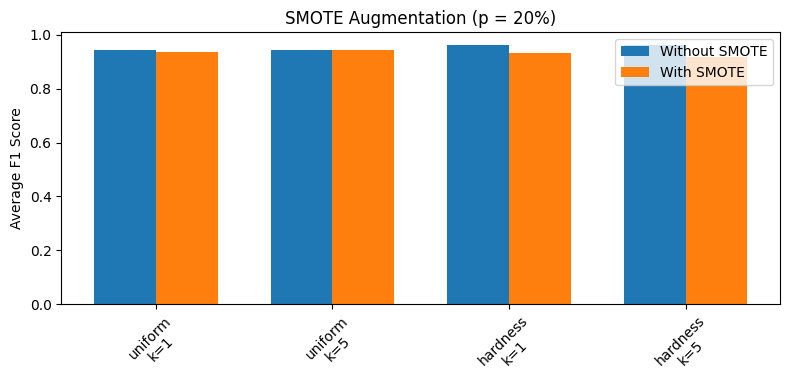

In [ ]:
labels, no_sm, with_sm = [], [], []

for scheme in ['uniform', 'hardness']:
    for k in k_list:
        labels.append(f"{scheme}\nk={k}")
        no_sm.append(res[scheme]['no_smote'][0])
        with_sm.append(res[scheme]['smote'][k][0])

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(8, 4))
plt.bar(x - width/2, no_sm, width, label='Without SMOTE')
plt.bar(x + width/2, with_sm, width, label='With SMOTE')
plt.xticks(x, labels, rotation=45)
plt.ylabel('Average F1 Score')
plt.title('SMOTE Augmentation (p = 20%)')
plt.legend()
plt.tight_layout()
plt.show()

## Part 2.3: Transfer Learning

We first pre-trained two CNNs a shallow two block model and a deeper three block model on digits 0 to 4 for five epochs, then set aside 20 % of digits 5 to 9 as a hold-out test. As a baseline, each network was trained from scratch on the full 80 % training split of digits 5 to 9 for five epochs, yielding a macro F1 of about 0.989. For transfer learning, we took the A-trained weights, froze all convolutional layers, and fine-tuned only the dense layers on increasingly larger fractions (10 %, 25 %, 50 %, 100 %) of the B training set again for five epochs each. Even with just 10 % of the labels, both architectures hit around 0.97 F1 on the hold-out—far above what direct training on that small subset would achieve and by 50 % they were almost indistinguishable from the full-data baseline, fully matching it at 100 %. The three block CNN pulled ahead slightly at intermediate data levels, but both models converged to the same top score. This clearly demonstrates that pre-training on a related digit task can drastically reduce new task labeling requirements while preserving near optimal accuracy.

Load & Prepare MNIST

In [ ]:
(x_tr, y_tr), (x_te, y_te) = tf.keras.datasets.mnist.load_data()
X_full = np.concatenate([x_tr, x_te], axis=0) / 255.0
y_full = np.concatenate([y_tr, y_te], axis=0)
X_full = X_full[..., None]  # add channel dimension

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Split into Sets A (0–4) and B (5–9), Hold-out B

In [ ]:
maskA = y_full < 5
maskB = y_full >= 5

xA, yA = X_full[maskA], y_full[maskA]
xB, yB = X_full[maskB], y_full[maskB] - 5  # re-label B to 0–4

xB_train, xB_hold, yB_train, yB_hold = train_test_split(
    xB, yB, test_size=0.2, stratify=yB, random_state=0
)

CNN Builder Function

In [ ]:
from tensorflow.keras import models, layers
def make_cnn(conv_filters, num_classes=5, input_shape=(28,28,1)):
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=input_shape))
    for f in conv_filters:
        model.add(layers.Conv2D(f, (3,3), activation='relu', padding='same'))
        model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy')
    return model

Epoch 1/5


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(None, 30), dtype=float32). Expected shape (None, 28, 28, 1), but input has incompatible shape (None, 30)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 30), dtype=float32)
  • training=True
  • mask=None

Pre-train on Set A

In [ ]:
cnn2 = make_cnn([32, 64])
cnn3 = make_cnn([32, 64, 128])

cnn2.fit(xA, yA, epochs=5, batch_size=128, verbose=0)
cnn3.fit(xA, yA, epochs=5, batch_size=128, verbose=0)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Direct-training Baseline on B

In [ ]:
def direct_train(conv_filters):
    model = make_cnn(conv_filters)
    model.fit(xB_train, yB_train, epochs=5, batch_size=128, verbose=0)
    preds = np.argmax(model.predict(xB_hold), axis=1)
    return f1_score(yB_hold, preds, average='macro')

f1_direct_2 = direct_train([32, 64])
f1_direct_3 = direct_train([32, 64, 128])

215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


Transfer-learning Evaluation Function

In [ ]:
def transfer_and_eval(base_model, conv_filters, p_list):
    results = []
    for p in p_list:
        n = int(len(xB_train) * p)
        idx = np.random.choice(len(xB_train), n, replace=False)
        xb, yb = xB_train[idx], yB_train[idx]

        model = make_cnn(conv_filters)
        model.set_weights(base_model.get_weights())
        # Freeze all but last two layers (the FC layers)
        for layer in model.layers[:-2]:
            layer.trainable = False
        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy')
        model.fit(xb, yb, epochs=5, batch_size=128, verbose=0)

        preds = np.argmax(model.predict(xB_hold), axis=1)
        results.append(f1_score(yB_hold, preds, average='macro'))
    return results

Run Transfer Experiments

In [ ]:
p_list  = [0.1, 0.25, 0.5, 1.0]
scores2 = transfer_and_eval(cnn2, [32, 64], p_list)
scores3 = transfer_and_eval(cnn3, [32, 64, 128], p_list)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


215/215 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


Plot Results

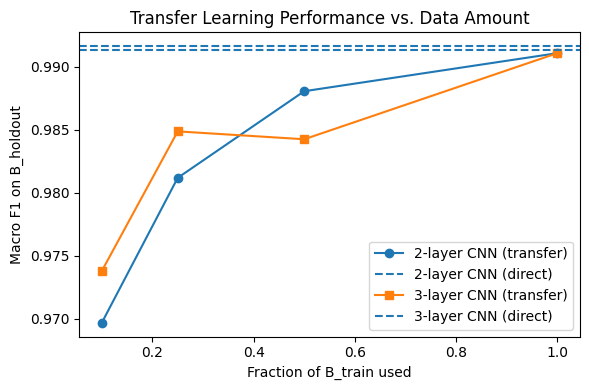

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(p_list, scores2, marker='o', label='2-layer CNN (transfer)')
plt.axhline(f1_direct_2, linestyle='--', label='2-layer CNN (direct)')
plt.plot(p_list, scores3, marker='s', label='3-layer CNN (transfer)')
plt.axhline(f1_direct_3, linestyle='--', label='3-layer CNN (direct)')
plt.xlabel('Fraction of B_train used')
plt.ylabel('Macro F1 on B_holdout')
plt.title('Transfer Learning Performance vs. Data Amount')
plt.legend()
plt.tight_layout()
plt.show()


# **Methods Project Part 3**

In this part, we load the Breast Cancer Wisconsin Diagnostic dataset directly from the provided ZIP file, automatically locate and read the .data file, assign meaningful column names, drop the non‐informative ID column, and encode the diagnosis as a binary label. We then split the data into an 80% training set and a 20% hold-out set and apply StandardScaler so that each feature contributes equally to downstream analyses.

Next, we construct a Functional-API autoencoder that compresses the 30 standardized features down to a 10-dimensional “bottleneck” representation and then reconstructs back to 30 dimensions, training it to minimize mean-squared reconstruction error. After fitting, we extract the 10-dimensional embeddings for every sample in the hold-out set.

To evaluate how well these learned embeddings capture intrinsic structure, we run both K-Means and Spectral Clustering on two representations
(1) the original 30-dimensional scaled features and
(2) the 10-dimensional autoencoder embeddings over cluster counts K = 1…5. For K = 1, we record a silhouette score of 0 (undefined for a single cluster). For K > 1, we compute the silhouette score, repeating each clustering 10 times with different random seeds to obtain mean ± standard deviation.

Finally, we plot the mean silhouette score versus K for each algorithm and representation, using error bars to display variability.


In [ ]:
#Imports
import zipfile
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers, Model, Input, optimizers
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


In [ ]:
zip_path = '/content/sample_data/breast+cancer+wisconsin+diagnostic.zip'
with zipfile.ZipFile(zip_path, 'r') as z:
    data_file = next(f for f in z.namelist() if f.endswith('.data'))
    print("Reading:", data_file)
    df = pd.read_csv(z.open(data_file), header=None)


Reading: wdbc.data


In [ ]:
feature_cols = [f'feature_{i}' for i in range(1, 31)]
df.columns   = ['id', 'diagnosis'] + feature_cols
df = df.drop(columns=['id'])
df['diagnosis'] = (df['diagnosis'] == 'M').astype(int)

X = df[feature_cols].values
y = df['diagnosis'].values


Train/hold-out split & standardization

In [ ]:
X_train, X_hold, y_train, y_hold = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
scaler         = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_hold_scaled  = scaler.transform(X_hold)

print("Shapes:", X_train_scaled.shape, X_hold_scaled.shape)


Shapes: (455, 30) (114, 30)


Build & train Functional‐API autoencoder

In [ ]:
input_dim    = X_train_scaled.shape[1]  # 30
encoding_dim = 10

ae_input   = Input(shape=(input_dim,), name='ae_input')
x_enc      = layers.Dense(16, activation='relu')(ae_input)
bottleneck = layers.Dense(encoding_dim, activation='relu', name='bottleneck')(x_enc)
x_dec      = layers.Dense(16, activation='relu')(bottleneck)
ae_out     = layers.Dense(input_dim, activation='linear')(x_dec)

autoenc = Model(ae_input, ae_out, name='autoencoder')
autoenc.compile(optimizer=optimizers.Adam(1e-3), loss='mse')
autoenc.fit(
    X_train_scaled, X_train_scaled,
    epochs=50, batch_size=32,
    validation_split=0.1,
    verbose=2
)


Epoch 1/50
13/13 - 5s - 393ms/step - loss: 1.1147 - val_loss: 0.8656
Epoch 2/50
13/13 - 0s - 13ms/step - loss: 1.0296 - val_loss: 0.8174
Epoch 3/50
13/13 - 0s - 13ms/step - loss: 0.9770 - val_loss: 0.7820
Epoch 4/50
13/13 - 0s - 13ms/step - loss: 0.9225 - val_loss: 0.7469
Epoch 5/50
13/13 - 0s - 8ms/step - loss: 0.8538 - val_loss: 0.7066
Epoch 6/50
13/13 - 0s - 10ms/step - loss: 0.7757 - val_loss: 0.6540
Epoch 7/50
13/13 - 0s - 7ms/step - loss: 0.7074 - val_loss: 0.6043
Epoch 8/50
13/13 - 0s - 11ms/step - loss: 0.6526 - val_loss: 0.5636
Epoch 9/50
13/13 - 0s - 11ms/step - loss: 0.6109 - val_loss: 0.5329
Epoch 10/50
13/13 - 0s - 10ms/step - loss: 0.5800 - val_loss: 0.5087
Epoch 11/50
13/13 - 0s - 7ms/step - loss: 0.5535 - val_loss: 0.4901
Epoch 12/50
13/13 - 0s - 7ms/step - loss: 0.5330 - val_loss: 0.4711
Epoch 13/50
13/13 - 0s - 8ms/step - loss: 0.5136 - val_loss: 0.4571
Epoch 14/50
13/13 - 0s - 7ms/step - loss: 0.4958 - val_loss: 0.4403
Epoch 15/50
13/13 - 0s - 7ms/step - loss: 0.4769

Extract 10-dim learned features for hold-out set

In [ ]:
encoder = Model(autoenc.input, autoenc.get_layer('bottleneck').output)
Z_hold  = encoder.predict(X_hold_scaled, batch_size=32)
print("Encoded hold-out shape:", Z_hold.shape)


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Encoded hold-out shape: (114, 10)


Defining clustering & silhouette scoring (K = 1–5)

In [ ]:
K_range = range(1, 5)

def cluster_scores(data, ClusterCls, ks, n_runs=10):
    means, stds = [], []
    for k in ks:
        if k == 1:
            # silhouette undefined for a single cluster
            means.append(0.0)
            stds.append(0.0)
            continue
        scores = []
        for seed in range(n_runs):
            if ClusterCls is KMeans:
                cl = ClusterCls(n_clusters=k, n_init=1, random_state=seed)
            else:
                cl = ClusterCls(n_clusters=k, assign_labels='discretize', random_state=seed)
            labels = cl.fit_predict(data)
            scores.append(silhouette_score(data, labels))
        means.append(np.mean(scores))
        stds.append(np.std(scores))
    return np.array(means), np.array(stds)


Plot and result

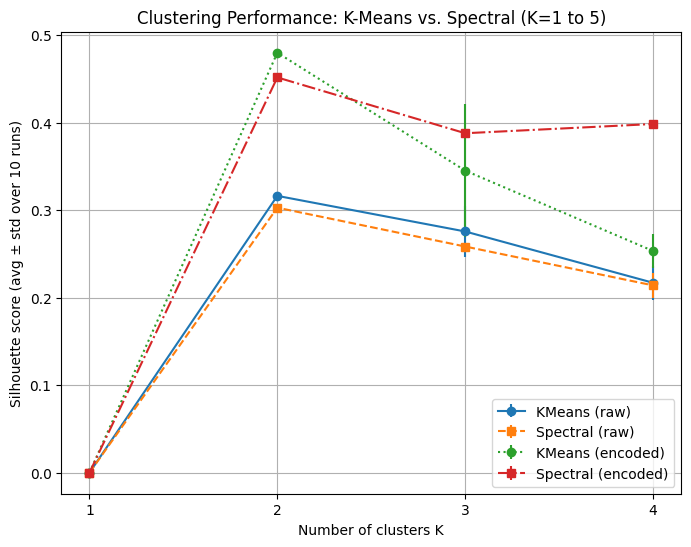

In [ ]:
raw_km_mean, raw_km_std   = cluster_scores(X_hold_scaled,       KMeans,            K_range)
raw_sc_mean, raw_sc_std   = cluster_scores(X_hold_scaled,       SpectralClustering, K_range)
feat_km_mean, feat_km_std = cluster_scores(Z_hold,             KMeans,            K_range)
feat_sc_mean, feat_sc_std = cluster_scores(Z_hold,             SpectralClustering, K_range)

plt.figure(figsize=(8,6))
for mean, std, label, fmt in [
    (raw_km_mean,  raw_km_std,  'KMeans (raw)',       'o-'),
    (raw_sc_mean,  raw_sc_std,  'Spectral (raw)',     's--'),
    (feat_km_mean, feat_km_std, 'KMeans (encoded)',   'o:'),
    (feat_sc_mean, feat_sc_std, 'Spectral (encoded)', 's-.'),
]:
    plt.errorbar(list(K_range), mean, yerr=std, fmt=fmt, label=label)

plt.xlabel('Number of clusters K')
plt.ylabel('Silhouette score (avg ± std over 10 runs)')
plt.title('Clustering Performance: K-Means vs. Spectral (K=1 to 5)')
plt.legend()
plt.xticks(list(K_range))
plt.grid(True)
plt.show()
